1. mogę usunąć niektóre kolumny (jakie?), zrobić model jeszcze raz i SHAP values i PFI
2. 

In [2]:
# 🖼️ Matplotlib settings

import warnings
import matplotlib.pyplot as plt
#sns.set_style("whitegrid")

plt.rcParams.update({
    'text.usetex': True,          # Enable LaTeX rendering
    'font.family': 'serif',       # Use serif fonts for a classic look
    'font.serif': ['Georgia'],    # Specify a serif font (e.g., Georgia)
    'figure.dpi': 200,            # Set the default DPI for clear visuals
    'figure.facecolor': 'white',  # Set the figure background color
    "axes.edgecolor": "grey",     # Border color for axes
    "axes.linewidth": 0.2,        # Border width for axes
    'axes.grid': True,            # Enable grid on axes
    'grid.color': 'grey',         # Grid color
    'grid.linestyle': '--',       # Dashed grid line style
    'grid.linewidth': 0.3,       # Grid line width
    'grid.alpha': 0.5,            # Grid transparency
    "axes.spines.top": False,     # Remove top spine
    "axes.spines.right": False,   # Remove right spine
    "legend.frameon": True,       # Enable frame around legends
    "legend.framealpha": 0.5      # Legend frame transparency
})

warnings.filterwarnings('ignore')

In [39]:
import pandas as pd
# --- Load Data ---
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]
df = pd.read_csv(url, names=column_names)
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [40]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Bins calculated per feature (Freedman-Diaconis):
Pregnancies                  16
Glucose                      18
BloodPressure                29
SkinThickness                61
Insulin                     663
BMI                          25
DiabetesPedigreeFunction     29
Age                          17
Outcome                       5
dtype: int64


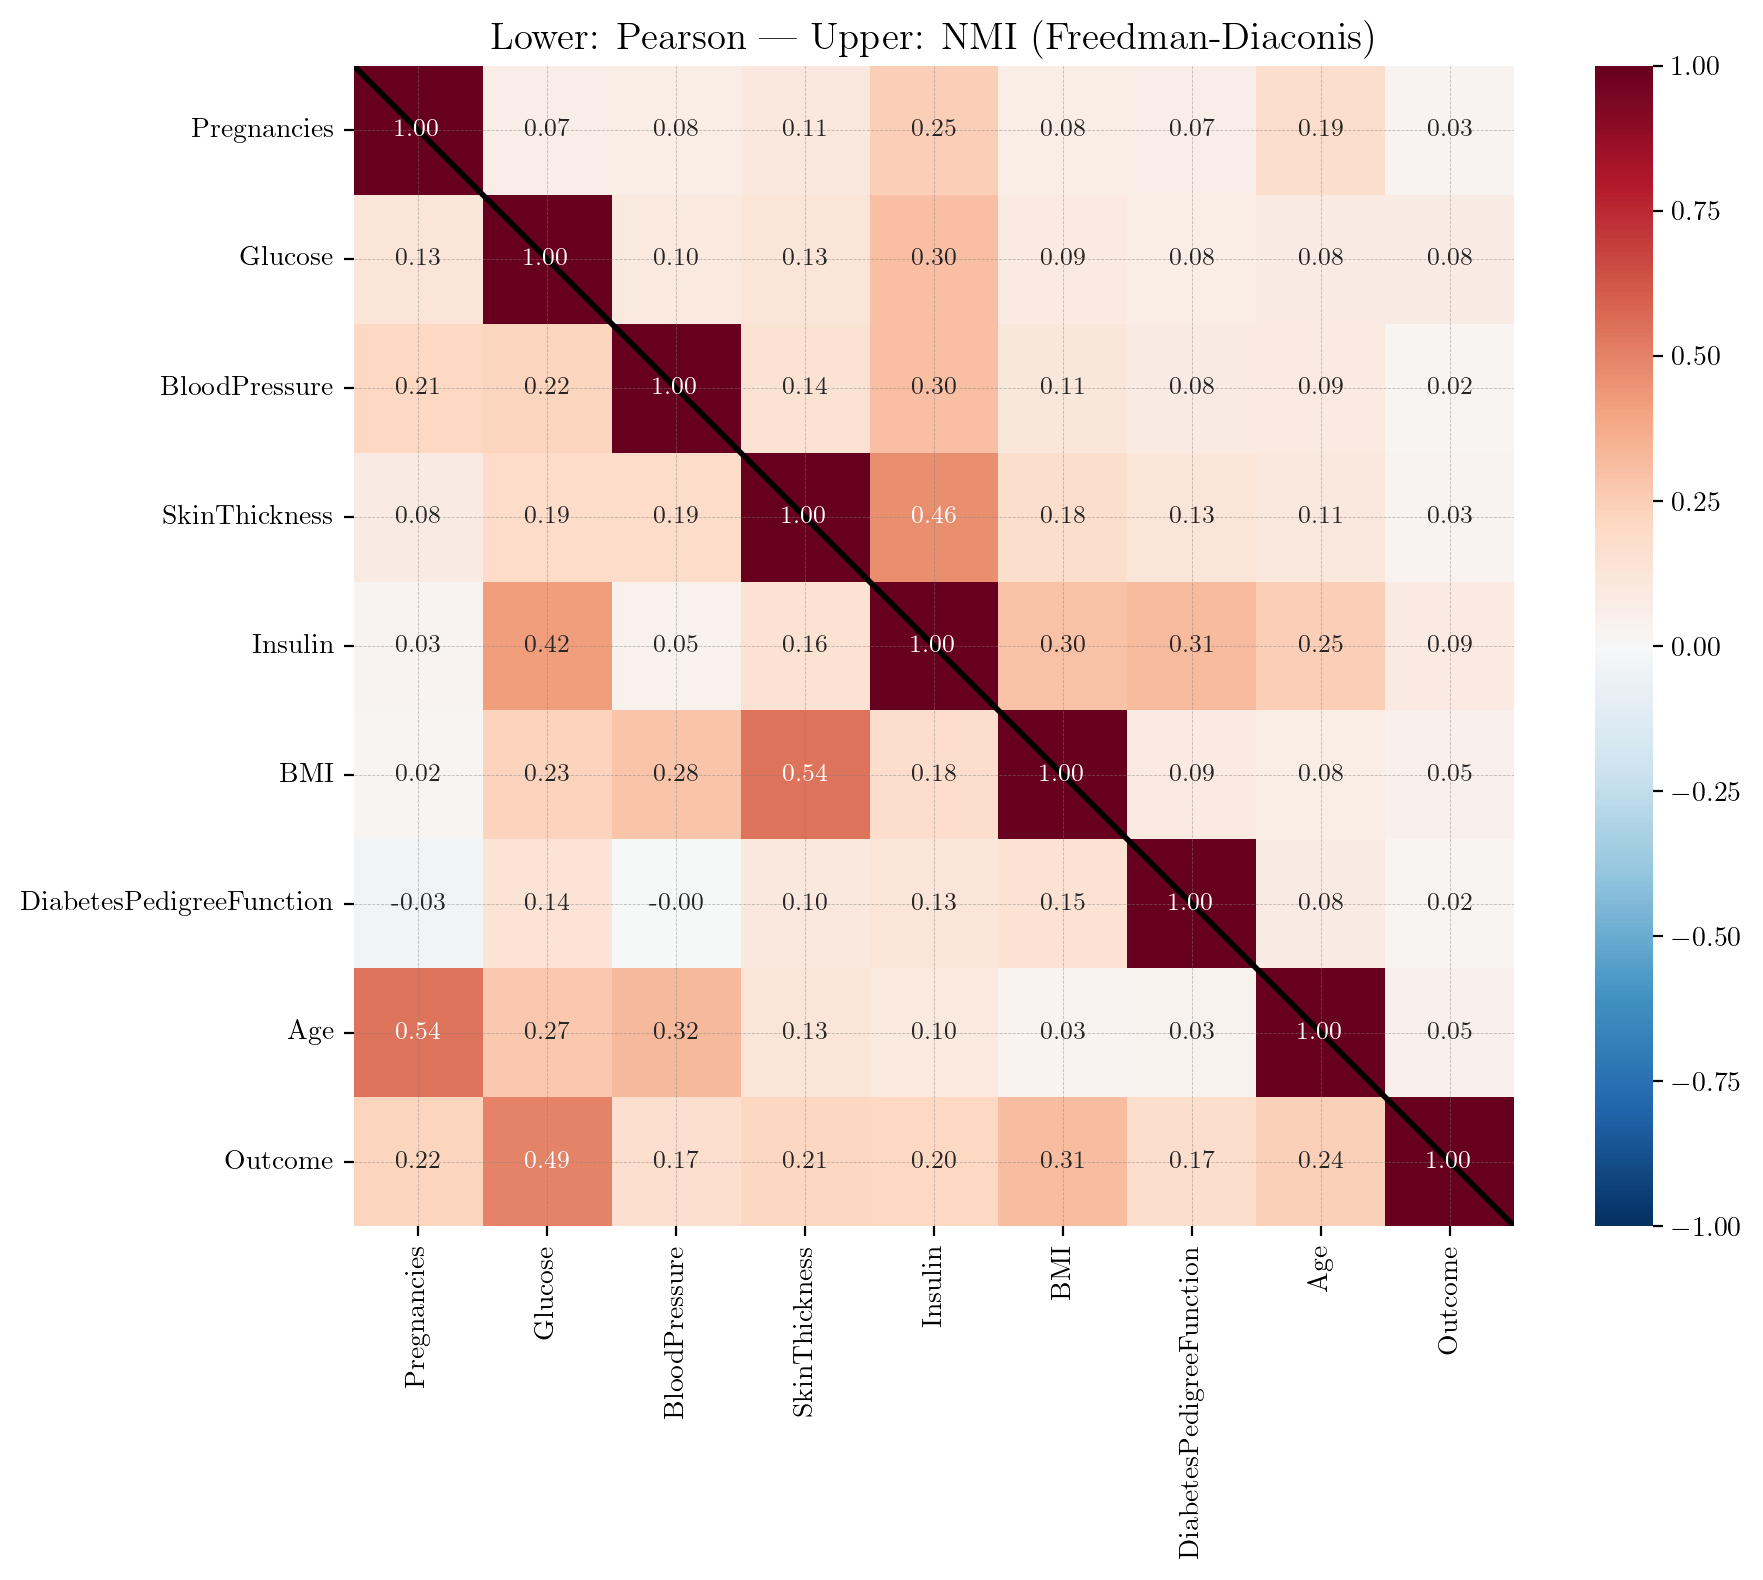

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from sklearn.impute import SimpleImputer

# --- Load Data ---
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]
df = pd.read_csv(url, names=column_names)

# --- Preprocessing (Crucial for FD Rule) ---
# The FD rule relies on IQR. If we leave "0" values (which are missing data)
# in columns like Insulin, the IQR will be skewed, leading to incorrect bin counts.
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# Impute with median to preserve distribution shape better than mean
imputer = SimpleImputer(strategy="median")
df_clean = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# --- Helper Function: Freedman-Diaconis Rule ---
def get_fd_bins(data):
    """Calculates number of bins using Freedman-Diaconis rule."""
    data = data.dropna()
    n = len(data)
    if n == 0: return 10 # Fallback
    
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25
    
    # Fallback if IQR is 0 (e.g., column is constant), default to Sturges
    if iqr == 0:
        return int(np.ceil(np.log2(n) + 1))
    
    bin_width = 2 * iqr / (n ** (1/3))
    data_range = data.max() - data.min()
    
    if bin_width == 0: return 10 # Prevent division by zero
    
    k = int(np.ceil(data_range / bin_width))
    return max(k, 2) # Ensure at least 2 bins

# --- 1. Calculate NMI (Upper Triangle) ---
nmi_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

# We now bin each column individually based on its own distribution
binned_data = pd.DataFrame()
bin_counts = {}

for col in df_clean.columns:
    k = get_fd_bins(df_clean[col])
    bin_counts[col] = k
    # Use pd.cut to discretize based on the calculated 'k'
    binned_data[col] = pd.cut(df_clean[col], bins=k, labels=False)

print("Bins calculated per feature (Freedman-Diaconis):")
print(pd.Series(bin_counts))

for col1 in df_clean.columns:
    for col2 in df_clean.columns:
        if col1 == col2:
            nmi_matrix.loc[col1, col2] = 1.0
        else:
            nmi = normalized_mutual_info_score(binned_data[col1], binned_data[col2])
            nmi_matrix.loc[col1, col2] = nmi

# --- 2. Calculate Pearson Correlation (Lower Triangle) ---
corr_matrix = df_clean.corr()

# --- 3. Combine Matrices ---
final_matrix = corr_matrix.copy()
for i in range(len(df.columns)):
    for j in range(i + 1, len(df.columns)):
        col1 = df.columns[i]
        col2 = df.columns[j]
        final_matrix.loc[col1, col2] = nmi_matrix.loc[col1, col2]

# --- 4. Plotting ---
plt.figure(figsize=(10, 8))
annot_matrix = final_matrix.applymap(lambda x: f"{x:.2f}")

sns.heatmap(
    final_matrix,
    cmap="RdBu_r",
    vmax=1.0, 
    vmin=-1.0, 
    center=0,
    square=True,
    annot=annot_matrix, 
    fmt="", 
    annot_kws={"size": 9}
)

plt.plot([0, len(df.columns)], [0, len(df.columns)], 'k-', linewidth=2)
plt.title("Lower: Pearson | Upper: NMI (Freedman-Diaconis)", fontsize=14)
plt.tight_layout()
plt.show()

--- NMI Matrix (Bins=10) ---


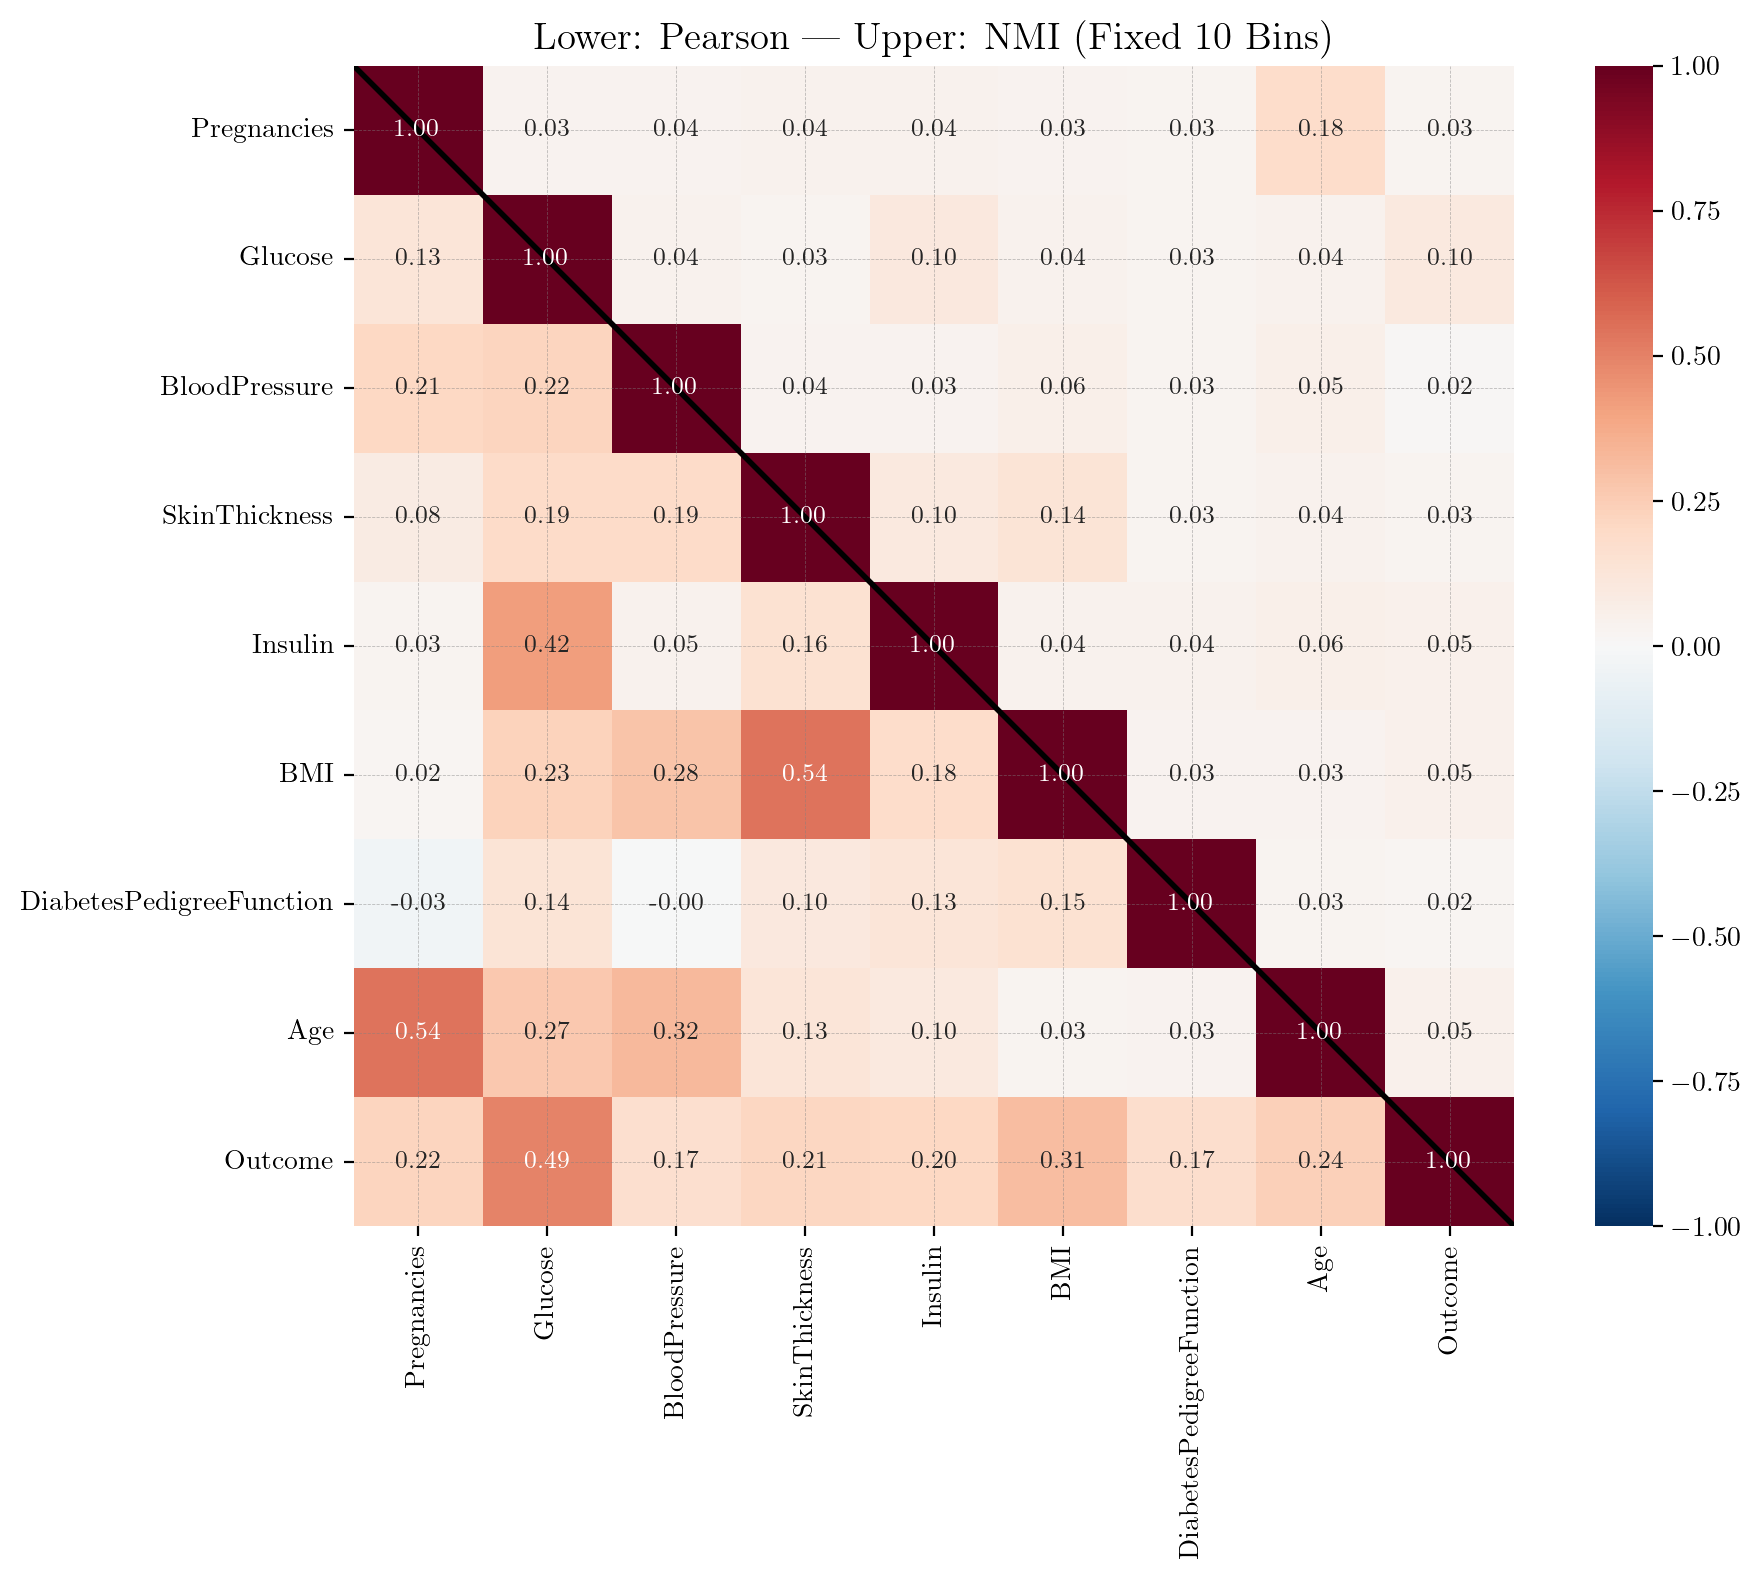

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from sklearn.impute import SimpleImputer

# --- Load Data ---
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]
df = pd.read_csv(url, names=column_names)

# --- Preprocessing ---
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

imputer = SimpleImputer(strategy="median")
df_clean = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# --- 1. Calculate NMI (Upper Triangle) ---
nmi_matrix1 = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

# FIXED BINNING: Use exactly 10 bins for all columns
# We apply this to the whole dataframe at once
df_binned = df_clean.apply(lambda x: pd.cut(x, bins=10, labels=False))

for col1 in df_clean.columns:
    for col2 in df_clean.columns:
        if col1 == col2:
            nmi_matrix1.loc[col1, col2] = 1.0
        else:
            nmi = normalized_mutual_info_score(df_binned[col1], df_binned[col2])
            nmi_matrix1.loc[col1, col2] = nmi

print("--- NMI Matrix (Bins=10) ---")

# --- 2. Calculate Pearson Correlation (Lower Triangle) ---
corr_matrix = df_clean.corr()

# --- 3. Combine Matrices ---
final_matrix = corr_matrix.copy()
for i in range(len(df.columns)):
    for j in range(i + 1, len(df.columns)):
        col1 = df.columns[i]
        col2 = df.columns[j]
        final_matrix.loc[col1, col2] = nmi_matrix1.loc[col1, col2]

# --- 4. Plotting ---
plt.figure(figsize=(10, 8))
annot_matrix = final_matrix.applymap(lambda x: f"{x:.2f}")

sns.heatmap(
    final_matrix,
    cmap="RdBu_r",
    vmax=1.0, 
    vmin=-1.0, 
    center=0,
    square=True,
    annot=annot_matrix, 
    fmt="", 
    annot_kws={"size": 9}
)

plt.plot([0, len(df.columns)], [0, len(df.columns)], 'k-', linewidth=2)
plt.title("Lower: Pearson | Upper: NMI (Fixed 10 Bins)", fontsize=14)
plt.tight_layout()
plt.show()

In [33]:
nmi_matrix

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.065063,0.076184,0.108374,0.248191,0.077201,0.069413,0.187114,0.027894
Glucose,0.065063,1.000000,0.097803,0.126542,0.304349,0.088135,0.076710,0.082382,0.081730
BloodPressure,0.076184,0.097803,1.000000,0.140645,0.302246,0.114452,0.082431,0.093457,0.018459
SkinThickness,0.108374,0.126542,0.140645,1.000000,0.463713,0.177105,0.125908,0.108989,0.028248
Insulin,0.248191,0.304349,0.302246,0.463713,1.000000,0.295547,0.313750,0.245175,0.093476
BMI,0.077201,0.088135,0.114452,0.177105,0.295547,1.000000,0.091651,0.075685,0.047386
DiabetesPedigreeFunction,0.069413,0.076710,0.082431,0.125908,0.313750,0.091651,1.000000,0.083197,0.020851
Age,0.187114,0.082382,0.093457,0.108989,0.245175,0.075685,0.083197,1.000000,0.048447
Outcome,0.027894,0.081730,0.018459,0.028248,0.093476,0.047386,0.020851,0.048447,1.000000


In [34]:
nmi_matrix1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.032506,0.037773,0.039566,0.043464,0.034687,0.028822,0.180911,0.027344
Glucose,0.032506,1.000000,0.043274,0.027376,0.104365,0.044579,0.029477,0.044094,0.096931
BloodPressure,0.037773,0.043274,1.000000,0.036399,0.032607,0.059472,0.029673,0.054860,0.015393
SkinThickness,0.039566,0.027376,0.036399,1.000000,0.098733,0.136126,0.030006,0.044463,0.030305
Insulin,0.043464,0.104365,0.032607,0.098733,1.000000,0.040801,0.042980,0.058635,0.049793
BMI,0.034687,0.044579,0.059472,0.136126,0.040801,1.000000,0.032978,0.033840,0.053670
DiabetesPedigreeFunction,0.028822,0.029477,0.029673,0.030006,0.042980,0.032978,1.000000,0.026240,0.020015
Age,0.180911,0.044094,0.054860,0.044463,0.058635,0.033840,0.026240,1.000000,0.048954
Outcome,0.027344,0.096931,0.015393,0.030305,0.049793,0.053670,0.020015,0.048954,1.000000


In [32]:
nmi_matrix.values - nmi_matrix1.values

array([[ 0.        ,  0.03255687,  0.03841047,  0.06880759,  0.20472666,
         0.04251452,  0.04059087,  0.00620324,  0.00055025],
       [ 0.03255687,  0.        ,  0.05452968,  0.09916593,  0.19998332,
         0.04355611,  0.04723352,  0.03828821, -0.01520032],
       [ 0.03841047,  0.05452968,  0.        ,  0.1042463 ,  0.26963957,
         0.0549792 ,  0.05275788,  0.03859744,  0.00306538],
       [ 0.06880759,  0.09916593,  0.1042463 ,  0.        ,  0.36498015,
         0.04097907,  0.09590187,  0.06452586, -0.00205686],
       [ 0.20472666,  0.19998332,  0.26963957,  0.36498015,  0.        ,
         0.25474606,  0.2707699 ,  0.1865398 ,  0.04368285],
       [ 0.04251452,  0.04355611,  0.0549792 ,  0.04097907,  0.25474606,
         0.        ,  0.05867323,  0.04184518, -0.00628365],
       [ 0.04059087,  0.04723352,  0.05275788,  0.09590187,  0.2707699 ,
         0.05867323,  0.        ,  0.05695764,  0.00083622],
       [ 0.00620324,  0.03828821,  0.03859744,  0.06452586,  0

In [41]:
import pandas as pd

# Direct link to the raw CSV from a stable repository
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

# The dataset usually comes without headers, so we define them manually
column_names = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]

data = pd.read_csv(url, names=column_names)

# Overview
print(f"Shape: {data.shape}")
data.head()

Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Brakuje preprocessingu
Na wszystkich kolumnach: Model F1 Weighted: 0.9558
Na wybranych () 0.9558

Model F1 Weighted: 0.7510


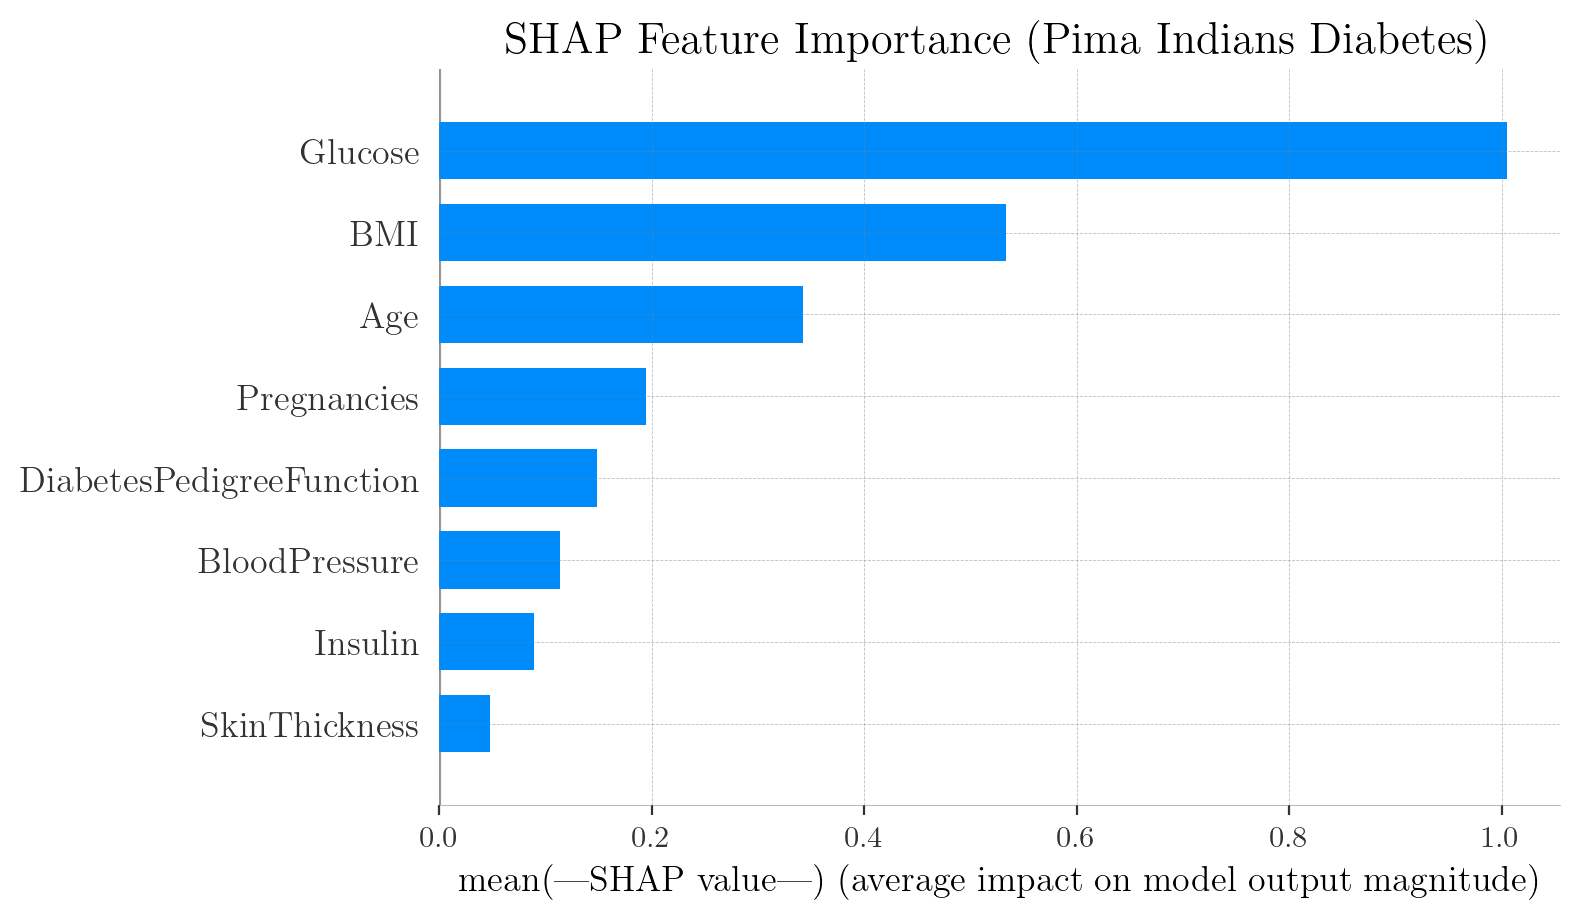

In [42]:
# --- Imports ---
import warnings
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# --- Load Pima Indians Diabetes Dataset ---
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
    "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]
df = pd.read_csv(url, names=column_names)

# --- Preprocessing ---

# 1. Handling Zeros (Domain-Specific Cleaning)
# Zeros in these columns indicate missing data, not actual zero values.
cols_with_zeros = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

# Split Features and Target
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Imputation (Replacing NaNs)
# We use 'median' to be robust against outliers (e.g., extremely high Insulin levels)
imputer = SimpleImputer(strategy="median")
# We impute and convert back to DataFrame to keep column names for SHAP
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

# 3. Scaling (Crucial for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed), columns=X.columns)

# --- Train Model ---
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# --- Check Performance ---
baseline_score = f1_score(y_test, model.predict(X_test_scaled), average='weighted')
print(f"Model F1 Weighted: {baseline_score:.4f}")

# --- Compute SHAP values ---
# We provide the SCALED training set as the background for the interventional method
explainer = shap.LinearExplainer(model, X_train_scaled, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test_scaled)

# --- Handle SHAP output shape ---
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
elif len(shap_values.shape) == 3:
    shap_values_class1 = shap_values[:, :, 1]
else:
    shap_values_class1 = shap_values

# --- SHAP Feature Importance Plot ---
plt.figure(figsize=(10, 6))
plt.title("SHAP Feature Importance (Pima Indians Diabetes)", fontsize=16)

shap.summary_plot(
    shap_values_class1,
    X_test_scaled,
    plot_type="bar",
    show=True
)

Model F1 Weighted: 0.9647


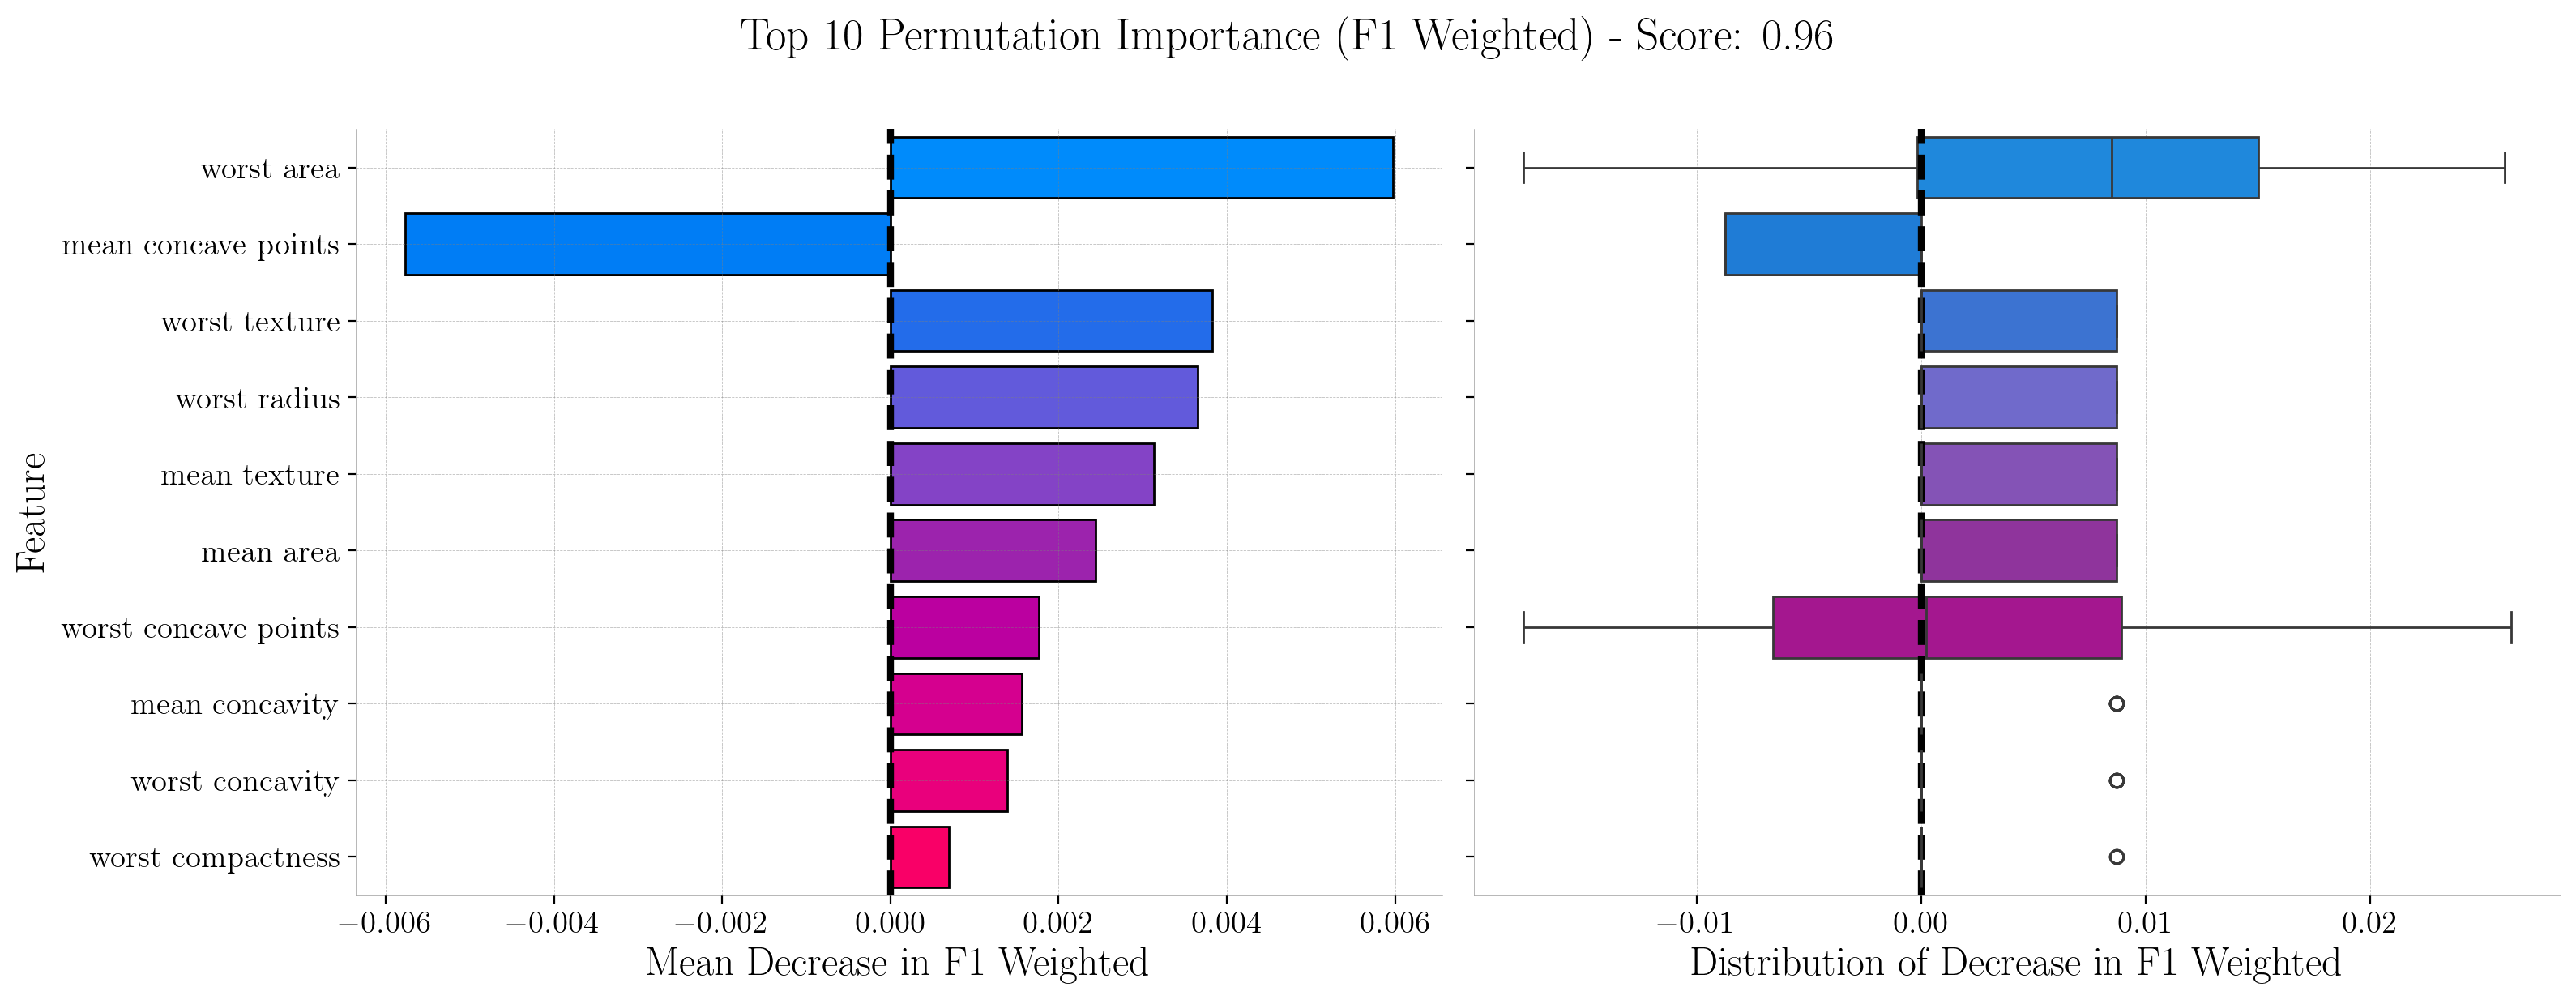

In [ ]:
# --- Imports ---
import warnings
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import shap
import matplotlib.colors as mcolors

# --- Load and Preprocess dataset ---
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# --- Calculate Baseline Score with the New Metric ---
y_pred_proba = model.predict_proba(X_test)[:, 1]
baseline_score = f1_score(y_test, model.predict(X_test), average='weighted')
metric_name = "F1 Weighted"
print(f"Model {metric_name}: {baseline_score:.4f}")

# --- Permutation Feature Importance ---
# Changed scoring from default (accuracy) to 'f1'
r = permutation_importance(model, X_test, y_test, n_repeats=50, random_state=42, scoring='f1_weighted')

# --- Process Results to Filter Top 10 ---
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
})

# 1. Create a column for absolute importance to use for sorting
importance_df["abs_importance_mean"] = importance_df["importance_mean"].abs()

# 2. Sort by absolute importance and select the top 10
top_10_importance_df = importance_df.sort_values("abs_importance_mean", ascending=False).head(10)
top_10_features = top_10_importance_df["feature"].tolist()

# 3. Create the "tidy" DataFrame for the boxplot and filter for top 10 features
importances_tidy_df = pd.DataFrame(r.importances.T, columns=X.columns)
importances_tidy_df = importances_tidy_df.melt(var_name='feature', value_name='importance')
top_10_tidy_df = importances_tidy_df[importances_tidy_df['feature'].isin(top_10_features)]

# --- Create consistent color mapping for the Top 10 ---
shap_cmap = shap.plots.colors.red_blue
num_features_to_plot = len(top_10_features)
# Adjust palette range to the number of features being plotted (10)
palette = [mcolors.to_hex(shap_cmap(i / num_features_to_plot)) for i in range(num_features_to_plot)]
feature_colors = dict(zip(top_10_features, palette))

# --- Plot setup ---
# Adjusted figure size for 10 features
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- Bar Plot (Left) ---
bar_colors = [feature_colors[f] for f in top_10_features]
axes[0].barh(
    top_10_importance_df["feature"],
    top_10_importance_df["importance_mean"],
    color=bar_colors,
    edgecolor="black"
)
axes[0].invert_yaxis()
axes[0].axvline(0, color='k', linestyle='--', linewidth=3)
# Updated x-axis label with new metric
axes[0].set_xlabel(f"Mean Decrease in {metric_name}", fontsize=18)
axes[0].set_ylabel("Feature", fontsize=18)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)

# --- Box Plot (Right) ---
sns.boxplot(
    data=top_10_tidy_df,
    x='importance',
    y='feature',
    order=top_10_features, # Ensure the same order as the bar plot
    orient='h',
    ax=axes[1],
    palette=feature_colors
)
axes[1].axvline(0, color='k', linestyle='--', linewidth=3)
# Updated x-axis label with new metric
axes[1].set_xlabel(f"Distribution of Decrease in {metric_name}", fontsize=18)
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)

# --- Title and layout ---
# Updated title with new metric and score
plt.suptitle(f"Top 10 Permutation Importance ({metric_name}) - Score: {baseline_score:.2f}", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

Model F1 Weighted: 0.9647


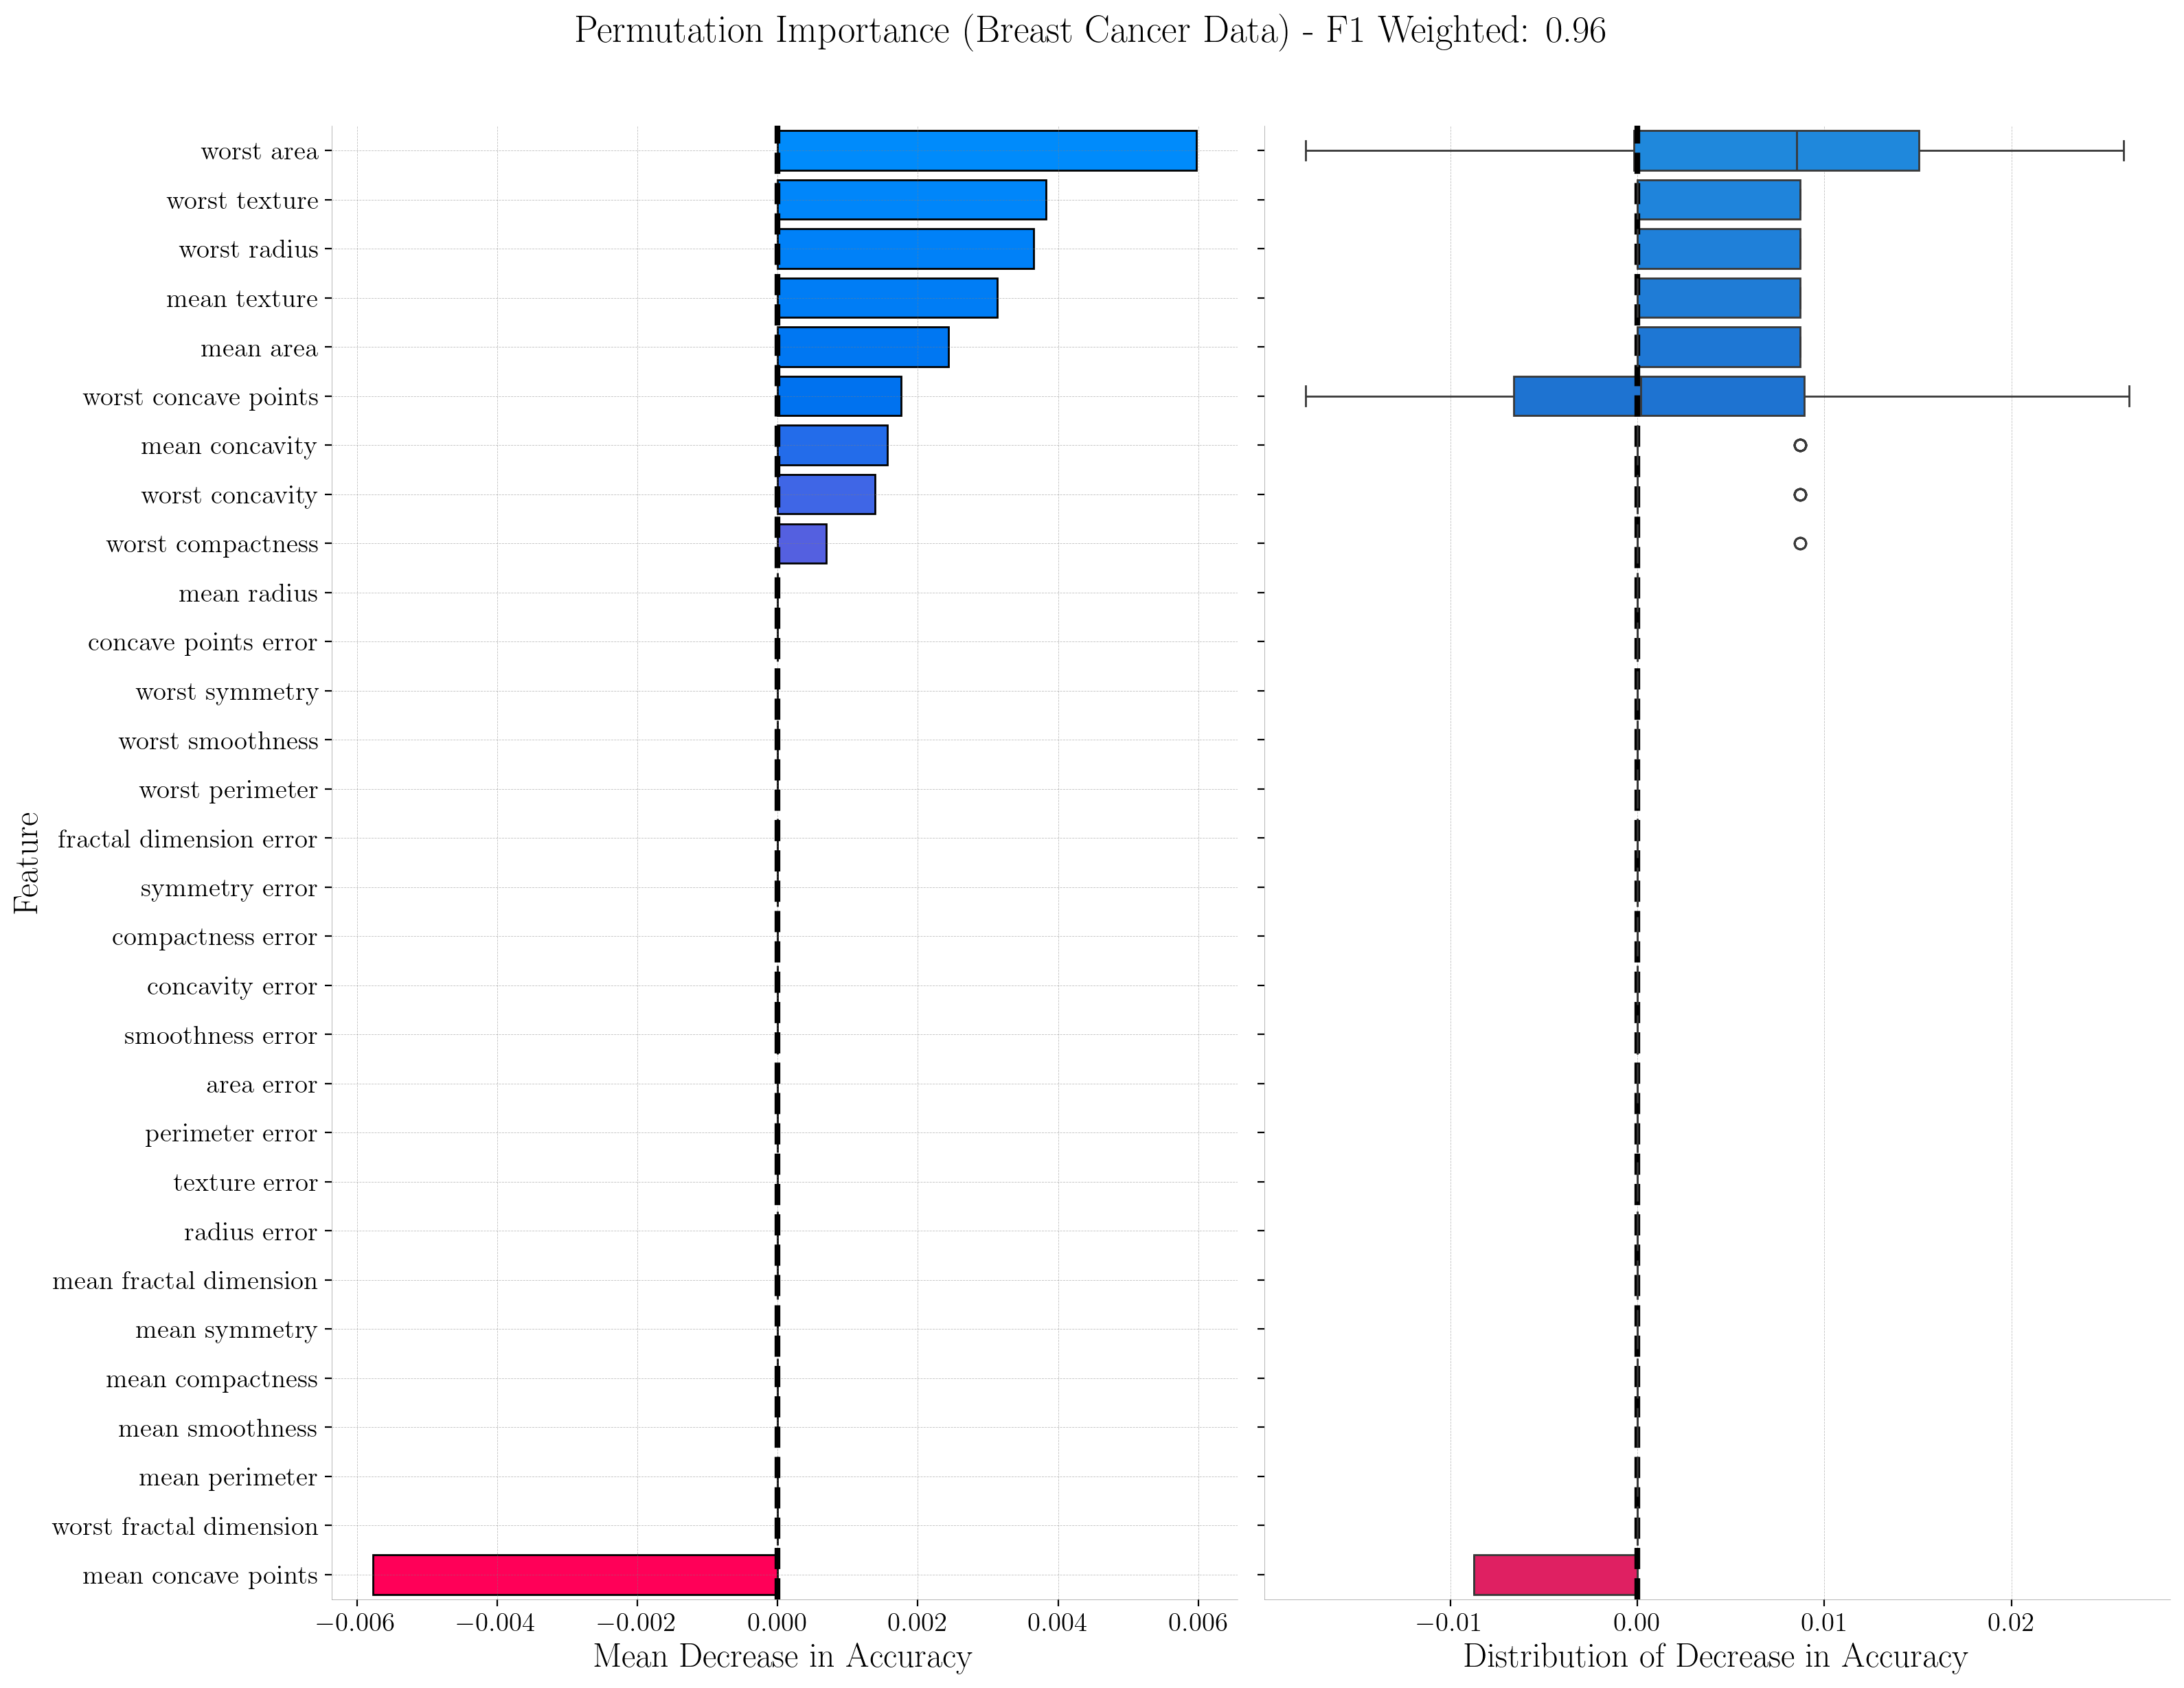

In [ ]:
### Original PFI 
# --- Imports ---
import warnings
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shap
import matplotlib.colors as mcolors

# --- Load dataset ---
data = load_breast_cancer()

# --- Preprocessing ---
# Create DataFrame to keep feature names
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

# Note: No need for dropna() or get_dummies() as this dataset is clean and numeric

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
baseline_score = f1_score(y_test, model.predict(X_test), average='weighted')
metric_name = "F1 Weighted"
print(f"Model {metric_name}: {baseline_score:.4f}")

# --- Permutation Feature Importance ---
# This shuffle process helps us understand which features the model relies on most
# 
r = permutation_importance(model, X_test, y_test, n_repeats=50, random_state=42, scoring='f1_weighted')

# --- Create importance DataFrame ---
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": r.importances_mean,
    "importance_std": r.importances_std
}).sort_values("importance_mean", ascending=False)

sorted_features = importance_df["feature"].tolist()

# --- Create long-form DataFrame for Boxplot ---
importances_tidy_df = pd.DataFrame(r.importances.T, columns=X.columns)
importances_tidy_df = importances_tidy_df.melt(var_name='feature', value_name='importance')

# --- Create consistent color mapping ---
shap_cmap = shap.plots.colors.red_blue
# Normalize color map for 30 features
palette = [mcolors.to_hex(shap_cmap(i / len(X.columns))) for i in range(len(X.columns))]
feature_colors = dict(zip(sorted_features, palette))

# --- Plot setup ---
# INCREASED HEIGHT: (16, 12) to accommodate 30 features
fig, axes = plt.subplots(1, 2, figsize=(16, 12), sharey=True)

# --- Bar Plot (Left) ---
bar_colors = [feature_colors[f] for f in sorted_features]
axes[0].barh(
    importance_df["feature"],
    importance_df["importance_mean"],
    color=bar_colors,
    edgecolor="black"
)
axes[0].invert_yaxis()
axes[0].axvline(0, color='k', linestyle='--', linewidth=3)
axes[0].set_xlabel(f"Mean Decrease in {metric_name}", fontsize=18)
axes[0].set_ylabel("Feature", fontsize=18)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=14)

# --- Box Plot (Right) ---
sns.boxplot(
    data=importances_tidy_df,
    x='importance',
    y='feature',
    order=sorted_features,
    orient='h',
    ax=axes[1],
    palette=feature_colors
)
axes[1].axvline(0, color='k', linestyle='--', linewidth=3)
axes[1].set_xlabel(f"Distribution of Decrease in {metric_name}", fontsize=18)
axes[1].set_ylabel("")
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=14)

# --- Title and layout ---
plt.suptitle(f"Permutation Importance (Breast Cancer Data) - {metric_name}: {baseline_score:.2f}", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()